# Forecasting Narrabeen Shoreline Positions

The goal of this notebook is provide insight of what goes into forecasting the shoreline position of the Narrabeen Collary Beach. We will be examining Profile 1, but note that this method is applicable to any of the different profiles.

We first import the modules that we need

In [1]:
# It seems like a lot of modules, but this notebook accomplishes many different objectives.

import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from scipy import interpolate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
sns.set_context('notebook',font_scale=1.5)
sns.set_style('ticks')
%matplotlib inline

Using Theano backend.


Now, let's import the raw dataset that will be used

In [2]:
profile = pd.read_csv('Narrabeen_Profiles_new.csv')

In [3]:
# here is what the dataset looks like

profile.head()

,Site,Profile ID,Date,Chainage,Elevation,Flag
0,NARRA,PF1,1976-04-27,0,9.09,EMERY
1,NARRA,PF1,1976-04-27,10,8.79,EMERY
2,NARRA,PF1,1976-04-27,20,8.06,EMERY
3,NARRA,PF1,1976-04-27,30,6.65,EMERY
4,NARRA,PF1,1976-04-27,40,4.86,EMERY


We can now begin to see the issues with this dataset. It appears that the shoreline position was never strictly collected and that the dataset has the Profile IDs in random order.

The format of this notebook is going to be split in to 3 sections.
* 1.) Obtaining shoreline positions
* 2.) Interpolating dates
* 3.) Training Neural Network

# 1.) Obtaining Shoreline Positions

To fix this issue we need to write some code to only get the information for profile 1, from there we can get the shoreline position.

In [4]:
# convert the dataframe above to an array

array = profile.values.astype(str)

In [5]:
# create 3 empty lists
chain = []
elevation = []
date = []

# in each line of the above dataframe, if the profile is not PF1, it is ignored
for line in array:
    if not line[1].startswith('PF1'): continue
        
    # if it is PF1, append all the information to the 3 empty lists
    chain.append(float(line[3]))
    elevation.append(float(line[4]))
    date.append(line[2])

# once the lists are complete we convert them to a dataframe to work with
chain_df = pd.DataFrame(chain)
elev_df = pd.DataFrame(elevation)
# in this last line, we introduced pd.to_datetime(), this converts from a string to datetime objects
date_df = pd.DataFrame(pd.to_datetime(date))

# each time a dataframe is created from a list, we must rename the column to be able to join them together
chain_df.rename(columns={0:'chainage'},inplace=True)
elev_df.rename(columns={0:'elevation'},inplace=True)
date_df.rename(columns={0:'Date'},inplace=True)

# join the dataframes together
main = chain_df.join(elev_df)
main = main.join(date_df)

In [6]:
# Here is the new dataframe with the information that we need

main.head()

,chainage,elevation,Date
0,0.0,9.09,1976-04-27
1,10.0,8.79,1976-04-27
2,20.0,8.06,1976-04-27
3,30.0,6.65,1976-04-27
4,40.0,4.86,1976-04-27


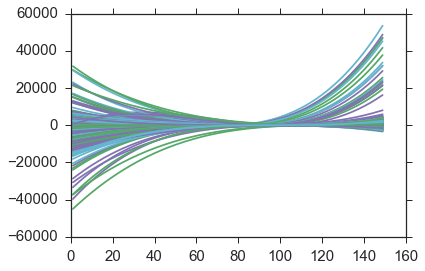

In [7]:
# convert the above dataframe to an array
array = main.values.astype(str)

# initialize an empty dataframe
new_x = pd.DataFrame()

# empty list
dates = []

#initialize variables to 0
count = 0
value = 0

# loop through each string in the array
for i in array[:]:
    count += 1    
    if i[1].startswith('-') and value >= 0:
        df_y = elev_df[count-3: count+1]
        df_x = chain_df[count-3:count+1]
        df_x = df_x.sort_values("chainage")
        
        x_array = df_x.values.astype(float)
        y_array = df_y.values.astype(float)
        
        x_array = x_array.reshape(-1,)
        y_array = y_array.reshape(-1,)
        
        x = x_array.tolist()
        y = y_array.tolist()
                
        f = interpolate.UnivariateSpline(x_array, y_array, s=0)
        x_new = np.arange(1,150,1)
        
        plt.plot(x,y,'x',x_new,f(x_new))   
        
        # y value to find is 0, that is the shoreline position
        yToFind = 0        
        yreduced = np.array(y) - yToFind        
        f_reduced = interpolate.UnivariateSpline(x, yreduced, s=0)
        df = pd.DataFrame(f_reduced.roots())       
        dates.append(i[2])
                
        if new_x.empty:
            new_x = df                
        else:
            new_x = new_x.append(df)
    value = float(i[1])
            
new_x.rename(columns = {0:"Chainage"}, inplace=True)
new_x = new_x.reset_index()
date_df = pd.DataFrame(pd.to_datetime(dates))
date_df.rename(columns={0:'Dates'}, inplace=True)

In [8]:
# setting up the data to plot

x = new_x.values
shoreline = []
for i in x:
    if not i[0] == 0: continue
    shoreline.append(i[1])
shoreline_df = pd.DataFrame(shoreline)
shoreline_df.rename(columns={0:'shoreline'},inplace=True)

shoreline_df = shoreline_df.join(date_df)
shoreline_df = shoreline_df[shoreline_df.shoreline != 0.07803480405574043]
plots = shoreline_df.set_index('Dates')

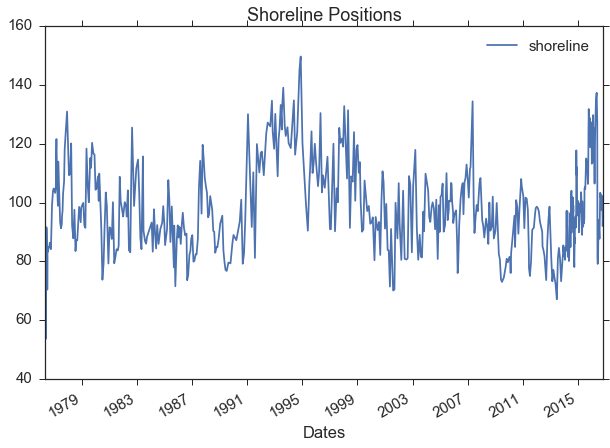

In [9]:
plt.figure()
plots.plot(figsize=(10,7))
plt.title('Shoreline Positions')

# 2.) Interpolating Dates

Now that we have the shoreline positions corresponding with the dates, we need to see how many days are inbetween each entry.

In [10]:
shoreline_df.tail()

,shoreline,Dates
589,102.762841,2016-09-12
590,97.428254,2016-09-26
591,102.184696,2016-10-14
592,92.002161,2016-10-25
593,98.053263,2016-11-11


We can see even from this small section that the days inbetween entries are not evenly spaced, which when working with a neural netowrk is preferred if one wants to obtain the lag values.

In [11]:
dt = shoreline_df.set_index('Dates')

In this dataset, the majority of the data was collected from 2005-present so I am going to ignore the time period before then. This is to avoid issues with interpolating too many data points.

In [12]:
dt = dt[320:]

In [13]:
def optimize(df, resample_method):
    greatest_so_far = 0
    integer = 0
    for i in range(1,resample_method+1):
        resample = df.resample(str(i)+'D').mean()
        length = len(resample)
        actual = len(resample.dropna())
        percent = float(actual)/float(length)
        
        if percent > greatest_so_far:
            greatest_so_far = percent
            integer = i
    greatest = greatest_so_far*100.0
    interp_percent = 100.0-greatest
    print 'Precent of actual values:         '+str(greatest)
    print 'Percent of interpolated values:   '+str(interp_percent)
    print 'Number of days to resample by:    '+str(integer)
    print 'Number of data entries:           '+str(len(resample))

The above function accepts the dataframe and determines the how many data points are real and interpolated by changing the resample parameter. 

In [14]:
optimize(dt, 12)

Precent of actual values:         54.1310541311
Percent of interpolated values:   45.8689458689
Number of days to resample by:    12
Number of data entries:           351


In [15]:
resample = dt.resample('12D').mean()

In [16]:
shoreline  = resample.interpolate()

In [17]:
shoreline.head()

,shoreline
Dates,
2005-05-13,92.283459
2005-05-25,98.188972
2005-06-06,104.094486
2005-06-18,110.000000
2005-06-30,102.337268


# 3.) LSTM Recurrent Neural Network

We are now ready to use this data in a neural network. Let's begin by using a new function.

In [18]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+1), 0]
        dataX.append(a)            
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

In [19]:
# convert the shoreline positions to an array and then normalize them to values between 0 and 1
# the neural network is extremely sensitive to large values, so by doing this we reduce any errors
dataset = shoreline.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [20]:
# split the dataset into 66% training, and 33% to test the data on
train_size = int(len(dataset)*0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [21]:
# look back is how many days back to train the data off of.
# if look_back is 1, X = t, Y = t+1
# if look_back is 2, X = t, Y = t+2
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [22]:
# Reshaping the arrays to be of the form (size, time_steps, features)

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [23]:
# Building the LSTM RNN model

model = Sequential()
model.add(LSTM(4, input_dim=1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
0s - loss: 0.0701
Epoch 2/100
0s - loss: 0.0148
Epoch 3/100
0s - loss: 0.0126
Epoch 4/100
0s - loss: 0.0107
Epoch 5/100
0s - loss: 0.0086
Epoch 6/100
0s - loss: 0.0064
Epoch 7/100
0s - loss: 0.0046
Epoch 8/100
0s - loss: 0.0035
Epoch 9/100
0s - loss: 0.0029
Epoch 10/100
0s - loss: 0.0027
Epoch 11/100
0s - loss: 0.0027
Epoch 12/100
0s - loss: 0.0027
Epoch 13/100
0s - loss: 0.0026
Epoch 14/100
0s - loss: 0.0026
Epoch 15/100
0s - loss: 0.0026
Epoch 16/100
0s - loss: 0.0027
Epoch 17/100
0s - loss: 0.0026
Epoch 18/100
0s - loss: 0.0026
Epoch 19/100
0s - loss: 0.0026
Epoch 20/100
0s - loss: 0.0026
Epoch 21/100
0s - loss: 0.0026
Epoch 22/100
0s - loss: 0.0025
Epoch 23/100
0s - loss: 0.0026
Epoch 24/100
0s - loss: 0.0026
Epoch 25/100
0s - loss: 0.0026
Epoch 26/100
0s - loss: 0.0026
Epoch 27/100
0s - loss: 0.0026
Epoch 28/100
0s - loss: 0.0027
Epoch 29/100
0s - loss: 0.0026
Epoch 30/100
0s - loss: 0.0026
Epoch 31/100
0s - loss: 0.0026
Epoch 32/100
0s - loss: 0.0026
Epoch 33/100
0s -

In [24]:
# making predictions on the training and test sets
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [25]:
# here we have to convert the normalized values back to the original scale

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [26]:
# print the mean squared error for the train and test predictions

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.49 RMSE
Test Score: 6.68 RMSE


In [27]:
# shifting the train and test datasets to be able to plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

get_dates = shoreline.reset_index()
get_dates = pd.DataFrame(pd.to_datetime(get_dates.Dates))

train_predict_plt = get_dates.join(pd.DataFrame(trainPredictPlot))
train_predict_plt.set_index('Dates', inplace=True)
train_predict_plt.rename(columns={0:'train'},inplace=True)

test_predict_plt = get_dates.join(pd.DataFrame(testPredictPlot))
test_predict_plt.set_index('Dates', inplace=True)
test_predict_plt.rename(columns={0:'test'},inplace=True)

In [38]:
main = shoreline.join(train_predict_plt)
main = main.join(test_predict_plt)

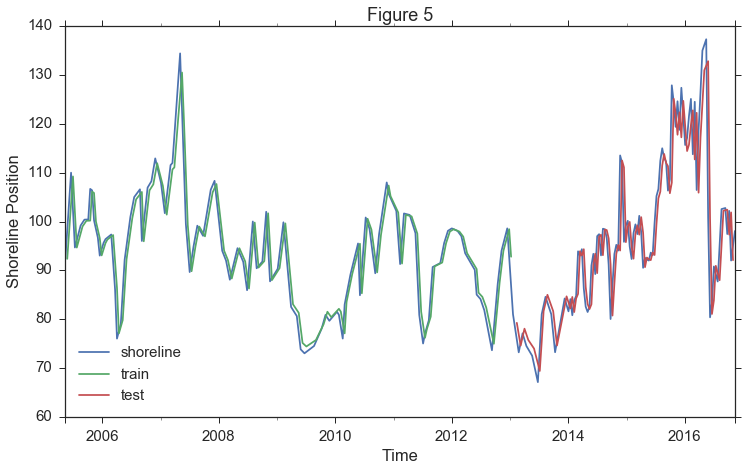

In [42]:
# plot figure
plt.figure(figsize=(12,7))
main.plot(figsize=((12,7)))
plt.title('Figure 5')
plt.xlabel('Time')
plt.ylabel('Shoreline Position')
plt.show()

We can see that when the look_back is 1, the forecast is extremely accurate. When the value of the look_back is increased the accuracy of the prediction will decrease due to less linearity in the training and target values. 

To further analyze the performance of the neural network and its ability to forecast future dates, the next step it to plot the root mean squared value as a function of days forecasting. The root mean squared is the average distance from the actual shoreline position that the neural network made.

To begin, we must repeat the process from before but forecast 2, 3, 4, 5, 6, and 7 data points ahead.

In [45]:
rmse_train = [3.49]
rmse_test = [6.68]

for i in range(2,8):
    
    dataset = shoreline.values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = scaler.fit_transform(dataset)

    # split the dataset into 66% training, and 33% to test the data on
    train_size = int(len(dataset)*0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    look_back = i
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    model = Sequential()
    model.add(LSTM(4, input_dim=1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)
    
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    rmse_train.append(math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])))
    rmse_test.append(math.sqrt(mean_squared_error(testY[0], testPredict[:,0])))

In [49]:
forecasetDays = [1,2,3,4,5,6,7]

rmse_trainDF = pd.DataFrame(rmse_train)
rmse_testDF = pd.DataFrame(rmse_test)

rmse_trainDF.rename(columns={0:'train RMSE'},inplace=True)
rmse_testDF.rename(columns={0:'test RMSE'},inplace=True)
forecastDaysDf = pd.DataFrame(forecasetDays)

forecastDaysDf = forecastDaysDf.join(rmse_trainDF)
forecastDaysDf = forecastDaysDf.join(rmse_testDF)

forecastDaysDf.set_index(0, inplace=True)

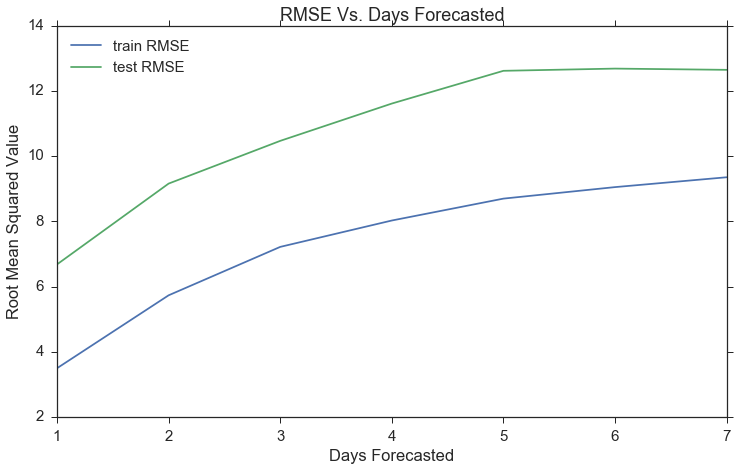

In [55]:
plt.figure()
forecastDaysDf.plot(figsize=(12,7))
plt.xlabel('Days Forecasted')
plt.ylabel('Root Mean Squared Value')
plt.title('RMSE Vs. Days Forecasted')